In [9]:
import pandas as pd
import numpy as np
import os
import re

# # Set working directory
# if not "/data/tables" in os.getcwd():
#     os.chdir("../data/tables")

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [10]:
sdf = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")

In [11]:
consumer_fraud_df = pd.read_csv("../data/tables/consumer_fraud_probability.csv")
merchant_fraud_df = pd.read_csv("../data/tables/merchant_fraud_probability.csv")

## Merchant Fraud
Check if there is missing data

In [12]:
merchant_sdf = spark.read.parquet("../data/tables/tbl_merchants.parquet")
merchant_df = merchant_sdf.toPandas()

In [13]:
#merchant_sdf.select("merchant_abn").distinct().count()
# 4026 entries distince values of merchant

fraud_union = set(merchant_fraud_df["merchant_abn"].unique()) # 61 unique cases
all_union = set(merchant_df["merchant_abn"].unique())
len(all_union.intersection(fraud_union))



48

Only 48/4026 merchants have fraud data
13/61 of the fraud data cannot be matched with any merchant abn

Try merge the merchant fraud data with transactions on order date + abn ????

## Costumer Fraud

In [14]:
costumer_sdf = spark.read.parquet("../data/tables/consumer_user_details.parquet")
costumer_df = costumer_sdf.toPandas()
costumer_df.head()

,user_id,consumer_id
0,1,1195503
1,2,179208
2,3,1194530
3,4,154128
4,5,712975


In [15]:
# costumer_sdf.distinct().count() # 499999 distinc values

In [16]:
from pyspark.sql import functions as F
transaction_df1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot")
transaction_df2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot")
transaction_df3 = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")
transaction = transaction_df1.union(transaction_df2).union(transaction_df3)

transaction = transaction.withColumn('log(dollar_value)',
                                     F.log(F.col('dollar_value')))
# lwr, upr = transaction.approxQuantile('log(dollar_value)', [0.25, 0.75], 0.001)
# iqr = upr - lwr
# lwr_bound = lwr - 1.5 * iqr
# upr_bound = upr + 1.5 * iqr
# lwr_bound, upr_bound = np.exp(lwr_bound), np.exp(upr_bound)

# new_transaction = transaction.where(
#     (F.col('dollar_value') >= lwr_bound) &
#     (F.col('dollar_value') <= upr_bound)
# )
merchant = spark.read.parquet("../data/tables/tbl_merchants.parquet")
merchant_abn = merchant.toPandas()['merchant_abn'].unique().tolist()
filtered_transaction = transaction.where(F.col('merchant_abn').isin(merchant_abn))
merchant_daily_transaction = filtered_transaction.groupby(['merchant_abn','order_datetime','user_id']).agg(
    F.countDistinct(F.col('order_id')).alias('no_order'),
    F.sum(F.col('dollar_value')).alias('dollar_amount')
) 


In [17]:
#merchant_daily_transaction.count() # 13584371

In [18]:
merchant_daily_transaction.select(max ('no_order'))

# MAX order is 3 

max(no_order)
3


The granularity level of the analysis is day level.

In [19]:
# entry 5 has high fraud rate, investigate this instance
# 82999039227,2021-12-19
# 35575706403,2022-02-20 entrie 43 
# 97884414539,2021-10-19,89.79919971536573

import datetime
merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 35575706403)
    & (F.col('order_datetime') == "2022-02-20")
)

# print(35575706403 in merchant_abn)


merchant_abn,order_datetime,user_id,no_order,dollar_amount
35575706403,2022-02-20,16556,1,50209.505438673325


In [20]:
merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 19492220327)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
   & (F.col('user_id') == 21706)
)

merchant_abn,order_datetime,user_id,no_order,dollar_amount
19492220327,2021-11-28,21706,1,1903.7191517251547


In [21]:
merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
#    (F.col('merchant_abn') == 19492220327)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
    (F.col('user_id') == 21706)
)

merchant_abn,order_datetime,user_id,no_order,dollar_amount
27093785141,2021-08-19,21706,1,297.1060630006161
32656335530,2021-05-15,21706,1,45.95924058414554
14639489823,2022-05-10,21706,1,73.82891944981822
79269463423,2022-06-10,21706,1,192.44624685911833
46804135891,2021-11-12,21706,1,15.1040241409343
93561083066,2021-09-04,21706,1,71.9166019734691
86578477987,2022-06-27,21706,1,25.86363096512127
77013874702,2022-05-03,21706,1,3.684141987613139
92207241352,2021-08-22,21706,1,75.9671958496898
63465140133,2022-08-20,21706,1,8.25922769029275


0        250.808535
1        408.057444
2        438.018593
3        445.260618
4        481.082374
           ...     
819    34199.004178
820    34926.955075
821    35535.112447
822    38156.497147
823    43409.810489
Name: dollar_amount, Length: 824, dtype: float64


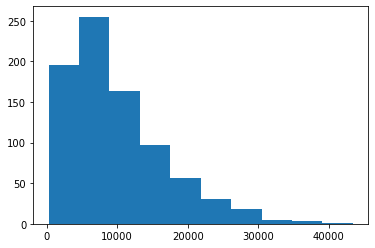

In [22]:
test_dollar_amout = merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 19492220327)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
#    & (F.col('user_id') == 21706)
).select("dollar_amount").toPandas()

import matplotlib.pyplot as plt



sorted = test_dollar_amout.sort_values(by="dollar_amount").reset_index()["dollar_amount"]
# plt.plot(sorted)
plt.hist(sorted) # mixure model?
# print(test_dollar_amout.mean())
# print(test_dollar_amout.std())
print(sorted)

# transaction level fraud detection
### idea 1 


fit a kmeans model to each merchant using ADK(automatic determination of Kmeans. granularity level is month since sku is unlikely to change too often), find std of each cluster, each cluster is seen as a normal distribution. 

When new transaction data come, first sort it to one cluster, then use quantile method of normal to determine the probability of it being a fraud.



### idea 2

Based on bayesian statistic. Fit a distribution (start with poisson) to every merchant. Use quantile method 


In [23]:
# user_id,order_datetime,fraud_probability
# 6228,2021-12-19,97.6298077657765 investigate this

merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('user_id') == 6228)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
   # &
   # (F.col('order_datetime') == datetime.date(2021, 12, 19))
 & (F.col('dollar_amount') <= 1279.315571)
& (F.col('dollar_amount') >= 1277.315571)

#    & (F.col('user_id') == 21706)
)

merchant_abn,order_datetime,user_id,no_order,dollar_amount
81776569986,2021-03-03,6228,1,1278.315571140402


,dollar_amount
0,502.107659
1,1278.315571
2,62.893256
3,230.216561
4,84.566328
...,...
553,74.979890
554,75.176187
555,60.498921
556,75.781941


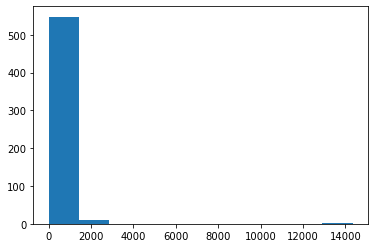

In [24]:
consumer = merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('user_id') == 6228)
  
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
#    &
#    (F.col('order_datetime') == datetime.date(2021, 12, 19))
#    & (F.col('user_id') == 21706)
).select("dollar_amount").toPandas()

plt.hist(consumer["dollar_amount"]) 
consumer

# For Sprint (ignore above code section)

## Mechant Data

In [25]:
# join merchant daily transaction data and merchant fraud
merchant_fraud_df.to_parquet("../data/temp/merchant_fraud")

merchant_fraud_sdf = spark.read.parquet("../data/temp/merchant_fraud")


In [26]:
# join merchant daily transaction data and merchant fraud
#join_df = merchant_fraud_sdf.join(merchant_daily_transaction, on=["merchant_abn","order_datetime"])
# join_df.count() #3981

join_df = merchant_fraud_sdf.join(merchant_daily_transaction, on=["merchant_abn","order_datetime"]).distinct()
# join_df.select("merchant_abn").distinct().count() #48
join_df.printSchema()


root
 |-- merchant_abn: long (nullable = true)
 |-- order_datetime: string (nullable = true)
 |-- fraud_probability: double (nullable = true)
 |-- user_id: long (nullable = true)
 |-- no_order: long (nullable = false)
 |-- dollar_amount: double (nullable = true)



In [27]:
#join_df.count()

In [28]:
# join dataframe only contains merchant transaction contained in merchant_fraud data
agg_sdf = join_df.groupBy(['merchant_abn','order_datetime']).agg(
     F.countDistinct(F.col('user_id')).alias('no_customer'),
     F.sum(F.col("no_order")).alias("total_order"),
     F.avg(F.col("dollar_amount")).alias("avg_dollar_amount"), # changed to avg for independence
     F.mean(F.col("fraud_probability")).alias("fraud_prob")
)

agg_sdf.count() # 95


#total_dollar_amount

95

In [29]:
agg_sdf.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- order_datetime: string (nullable = true)
 |-- no_customer: long (nullable = false)
 |-- total_order: long (nullable = true)
 |-- avg_dollar_amount: double (nullable = true)
 |-- fraud_prob: double (nullable = true)



(array([ 7., 43., 17.,  5.,  3.,  3., 12.,  2.,  1.,  2.]),
 array([18.21089143, 25.49940913, 32.78792684, 40.07644454, 47.36496225,
        54.65347995, 61.94199765, 69.23051536, 76.51903306, 83.80755077,
        91.09606847]),
 <BarContainer object of 10 artists>)

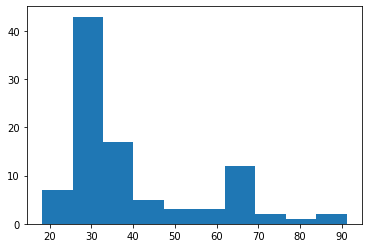

In [30]:
# histogram of fraud distribution
agg_df = agg_sdf.toPandas()

plt.hist(agg_df["fraud_prob"])

## test normal on the most major merchant

In [89]:
# find most major merchant

test_transaction = filtered_transaction.groupby(['merchant_abn','order_datetime']).agg(
    F.countDistinct(F.col('user_id')).alias('no_customer'),
    F.countDistinct(F.col("order_id")).alias("total_order"),
    F.avg(F.col("dollar_value")).alias("avg_dollar_value"), # changed to average per order for independence
) 


max = test_transaction.groupby("merchant_abn").agg(
    F.sum(F.col("total_order")).alias("total_all_time_order") 
).agg(
    F.max(F.col("total_all_time_order")).alias("max")
).collect()[0]["max"]


max_abn = test_transaction.groupby("merchant_abn").agg(
    F.sum(F.col("total_order")).alias("total_all_time_order") 
).where(
    F.col("total_all_time_order") ==  max
).collect()[0]["merchant_abn"]

In [96]:
# test 2nd and 3rd as well
order_abn = test_transaction.groupby("merchant_abn").agg(
    F.sum(F.col("total_order")).alias("total_all_time_order") 
).orderBy(
    F.col("total_all_time_order"),
    ascending=False
)

In [97]:
order_abn.head(3)

[Row(merchant_abn=24852446429, total_all_time_order=289513),
 Row(merchant_abn=86578477987, total_all_time_order=272674),
 Row(merchant_abn=64203420245, total_all_time_order=260780)]

In [92]:
max_abn_agg = test_transaction.where(
    F.col("merchant_abn") == max_abn
).toPandas()

snd_abn_agg = test_transaction.where(
    F.col("merchant_abn") == 86578477987
).toPandas()

trd_abn_agg = test_transaction.where(
    F.col("merchant_abn") == 64203420245
).toPandas()

In [94]:
max_abn

24852446429

(array([  1.,   1.,  12.,  41.,  94., 146., 165.,  96.,  36.,  14.]),
 array([26.00845407, 26.6825839 , 27.35671373, 28.03084356, 28.70497339,
        29.37910322, 30.05323305, 30.72736288, 31.40149271, 32.07562254,
        32.74975237]),
 <BarContainer object of 10 artists>)

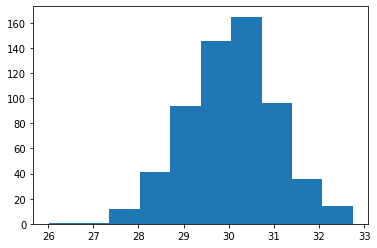

In [93]:
plt.hist(max_abn_agg["avg_dollar_value"])

In [88]:
max_abn_agg.head()

,merchant_abn,order_datetime,no_customer,total_order,avg_dollar_amount,fraud_prob
0,48534649627,2021-11-26,282,283,153.301320,29.005907
1,48534649627,2021-11-29,257,260,162.887116,28.360522
2,48534649627,2021-11-27,271,272,154.291071,28.337370


In [ ]:
max_merchant = agg_sdf.where(
    F.col("merchant")
)

In [31]:
filtered_transaction.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- log(dollar_value): double (nullable = true)



### standardize customer number, total order, total_dollar_amount by its mean and var

In [32]:
# first find the average 
labeled_merchant = merchant_fraud_df['merchant_abn'].unique().tolist()
labeled_merchant_transaction = transaction.where(F.col('merchant_abn').isin(labeled_merchant))

all_time_daily_merchant_transaction = labeled_merchant_transaction.groupby(['merchant_abn','order_datetime']).agg(
    F.countDistinct(F.col('user_id')).alias('no_customer'),
    F.countDistinct(F.col("order_id")).alias("total_order"),
    F.avg(F.col("dollar_value")).alias("avg_dollar_value"), # changed to average per consumer for independence
) 

all_time_daily_merchant_transaction.count()

18656

In [33]:
all_time_agg = all_time_daily_merchant_transaction.groupBy("merchant_abn").agg(
    F.avg(F.col("no_customer")).alias("avg_daily_no_customer"),
    F.stddev(F.col("no_customer")).alias("stddev_daily_no_customer"),
    F.avg(F.col("total_order")).alias("avg_daily_total_order"),
    F.stddev(F.col("total_order")).alias("stddev_daily_total_order"),
    F.avg(F.col("avg_dollar_value")).alias("avg_daily_avg_dollar_value"), # avg customer spending
    F.stddev(F.col("avg_dollar_value")).alias("stddev_daily_avg_dollar_value"),
)

all_time_agg.printSchema()


root
 |-- merchant_abn: long (nullable = true)
 |-- avg_daily_no_customer: double (nullable = true)
 |-- stddev_daily_no_customer: double (nullable = true)
 |-- avg_daily_total_order: double (nullable = true)
 |-- stddev_daily_total_order: double (nullable = true)
 |-- avg_daily_avg_dollar_value: double (nullable = true)
 |-- stddev_daily_avg_dollar_value: double (nullable = true)



In [34]:
#all_time_agg.count() # 61 checked
all_time_agg_df = all_time_agg.toPandas()

In [35]:
agg_df.head(1)

,merchant_abn,order_datetime,no_customer,total_order,avg_dollar_amount,fraud_prob
0,27093785141,2021-11-27,116,117,400.528232,29.539473


In [36]:
# discuss about the modeling idea during standup, use normal(t test) for now
# Joint probability 
# assume independence (avg spending and number of customer are independent )
# cdf F(x<X, y<Y) = F(x)F(y)
# since order and customer are highly correlated(almost identical), we choose avg_dollar_value as X and 
# no of orders as Y



from scipy import stats
def two_side_p_val(mean, stddev, test):
    norm_dist = stats.norm(loc=mean, scale=stddev)
    if test > mean:
        return 2* (1-norm_dist.cdf(test))
    else:
        return 2*norm_dist.cdf(test)

def join_prob_p_val(mux, stdx, muy, stdy, testx, testy):
    distx = stats.norm(loc=mux, scale=stdx)
    disty = stats.norm(loc=muy, scale=stdy)
    joint_prob = distx.cdf(testx) * disty.cdf(testy)
    if joint_prob>0.5:
        return 2* (1-joint_prob)
    else:
        return 2*joint_prob


agg_join_df = all_time_agg_df.merge(agg_df, on="merchant_abn")

agg_join_df["no_order_p_val"] = agg_join_df[['avg_daily_total_order','stddev_daily_total_order',"total_order"]].\
    apply(lambda row:two_side_p_val(row[0],row[1],row[2]),axis=1)

agg_join_df["no_customer_p_val"] = agg_join_df[['avg_daily_no_customer','stddev_daily_no_customer',"no_customer"]].\
    apply(lambda row:two_side_p_val(row[0],row[1],row[2]),axis=1)

agg_join_df["avg_dollar_value_p_val"] = agg_join_df[['avg_daily_avg_dollar_value','stddev_daily_avg_dollar_value',"avg_dollar_amount"]].\
    apply(lambda row:two_side_p_val(row[0],row[1],row[2]),axis=1)


# not good feature
agg_join_df["joint_dist_p_val"] =  agg_join_df[['avg_daily_avg_dollar_value','stddev_daily_avg_dollar_value',\
    'avg_daily_total_order','stddev_daily_total_order','avg_dollar_amount',"total_order"]].\
         apply(lambda row:join_prob_p_val(row[0],row[1],row[2],row[3],row[4],row[5]),axis=1)

# # p_val_x * p_val_y
# agg_join_df["p_val_multiple"] = agg_join_df[['avg_dollar_value_p_val','no_order_p_val']].apply(lambda row:
# np.exp(row[0])*np.exp(row[1]),axis=1)




/Users/ke/opt/anaconda3/envs/ML/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/ke/opt/anaconda3/envs/ML/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/ke/opt/anaconda3/envs/ML/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [37]:
# just one transaction, so dev is nan
transaction.where(
    F.col("merchant_abn") == 67264251405
)

user_id,merchant_abn,dollar_value,order_id,order_datetime,log(dollar_value)
22239,67264251405,51876.637563877644,09206be9-492c-414...,2021-10-19,10.856623824531193


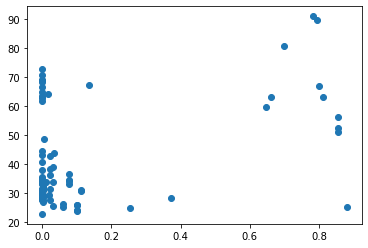

In [38]:
# graphs
agg_join_df = agg_join_df.dropna()
plt.scatter(agg_join_df["no_order_p_val"],agg_join_df["fraud_prob"])
# agg_join_df["no_order_p_val"] = agg_join_df["no_order_p_val"]

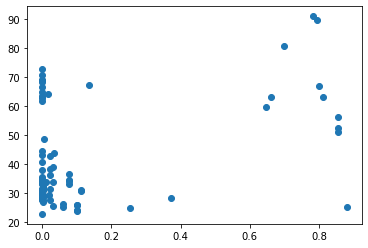

In [39]:
plt.scatter(agg_join_df["no_customer_p_val"],agg_join_df["fraud_prob"])

#plt.scatter(np.log(agg_join_df["no_customer_p_val"]),agg_join_df["fraud_prob"])

In [40]:
agg_join_df.loc[agg_join_df["fraud_prob"] >= 90]

,merchant_abn,avg_daily_no_customer,stddev_daily_no_customer,avg_daily_total_order,stddev_daily_total_order,avg_daily_avg_dollar_value,stddev_daily_avg_dollar_value,order_datetime,no_customer,total_order,avg_dollar_amount,fraud_prob,no_order_p_val,no_customer_p_val,avg_dollar_value_p_val,joint_dist_p_val
36,35575706403,1.072464,0.261154,1.072464,0.261154,11275.779495,8551.62989,2022-02-20,1,1,50209.505439,91.096068,0.781415,0.781415,0.000005,0.781413


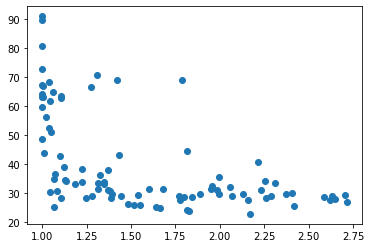

In [41]:




plt.scatter(np.exp(agg_join_df["avg_dollar_value_p_val"]),agg_join_df["fraud_prob"])
# plt.scatter(np.log(agg_join_df["total_dollar_value_p_val"]),agg_join_df["fraud_prob"])


In [42]:
# Joint probability 
# assume independence (avg spending and number of customer are independent )
# cdf F(x<X, y<Y) = F(x)F(y)



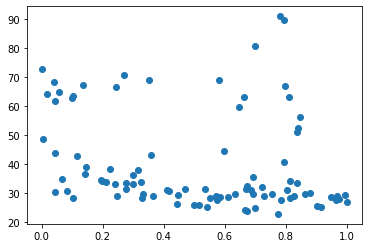

In [43]:
# not optimal....
plt.scatter(agg_join_df["joint_dist_p_val"],agg_join_df["fraud_prob"])

In [44]:
# # p val multiple

# plt.scatter(agg_join_df["p_val_multiple"],agg_join_df["fraud_prob"])

In [45]:
agg_join_df.to_csv("../data/curated/merchant_fraud_join.csv")

dollar amount it self has a nice negtaive relation
when we use joint prob it is almost uniformly distributed
it appears to be the dollar amount is the most significant feature in terms of determine fraud probability

This doesn't suggest that other features we have are noises. Maybe the other features contributes to distinguish the fraud from the normal ones.

## additional analysis from customer fraud featues

In [46]:
# consumer: fraud_order_share, fraud_consumer_share, weighted_fraud_value_share
consumer_fraud_sdf = spark.read.parquet("../data/curated/consumer_fraud.parquet")

merchant_transaction_on_fraud_day = labeled_merchant_transaction.join(merchant_fraud_sdf.withColumnRenamed("fraud_probability", "merchant_fraud_prob"),on=["merchant_abn","order_datetime"])

# merchant_transaction_on_fraud_day_with_consumer_prob = merchant_transaction_on_fraud_day.join(consumer_fraud_sdf.withColumnRenamed("fraud_probability","consumer_fraud_prob").select(""), on="order_datetime"])

merchant_agg_on_fraud_day = merchant_transaction_on_fraud_day.groupBy(["merchant_abn","order_datetime"]).agg(
    F.countDistinct(F.col('user_id')).alias('no_customer'),
    F.countDistinct(F.col("order_id")).alias("no_order"),
    F.sum(F.col("dollar_value")).alias("sum_dollar_value"), 
)

In [47]:
fraud_transaction = merchant_transaction_on_fraud_day.join(consumer_fraud_sdf.withColumnRenamed("fraud_probability","consumer_fraud_prob").distinct(), on=["user_id", "order_datetime"])


In [48]:
fraud_transaction.head(1)

[Row(user_id=3101, order_datetime=datetime.date(2021, 4, 17), merchant_abn=91880575299, dollar_value=105193.88578925544, order_id='2ab65c8f-11b2-41cb-8889-001ce62c005d', log(dollar_value)=11.563560457722723, merchant_fraud_prob=32.99497823665355, consumer_fraud_prob=91.42192091901347)]

In [77]:
fraud_transaction_agg = fraud_transaction.groupBy(["merchant_abn","order_datetime"]).agg(
    F.sum(F.col("consumer_fraud_prob") * F.col("dollar_value")*0.01).alias("weighted_fraud_value"),
    F.countDistinct(F.col("user_id")).alias("no_fraud_consumer"),
    F.countDistinct(F.col("order_id")).alias("no_fraud_order"),
    F.mean(F.col("merchant_fraud_prob")).alias("merchant_fraud_prob"),   # any other way to work around this? want to preserve merchant_fraud_prob
    F.sum(F.col("consumer_fraud_prob")*0.01).alias("no_fraud_consumer_weighted"),
)

In [50]:
merchant_fraud_share_agg = merchant_agg_on_fraud_day.join(fraud_transaction_agg, on=["merchant_abn","order_datetime"])\
    .withColumn(
        'fraud_customer_share',
        F.col("no_fraud_consumer")/F.col('no_customer')
    ).withColumn(
        'fraud_order_share',
        F.col("no_fraud_order")/F.col('no_order')
    ).withColumn(
        'weighted_fraud_value_share',
        F.col("weighted_fraud_value")/F.col('sum_dollar_value')
    )


In [51]:
merchant_fraud_share_agg_df = merchant_fraud_share_agg.toPandas()

In [52]:
merchant_fraud_share_agg_df.head(1)

,merchant_abn,order_datetime,no_customer,no_order,sum_dollar_value,weighted_fraud_value,no_fraud_consumer,no_fraud_order,merchant_fraud_prob,fraud_customer_share,fraud_order_share,weighted_fraud_value_share
0,11149063370,2021-08-28,1,1,47346.113374,40851.783402,1,1,56.437613,1.0,1.0,0.862833


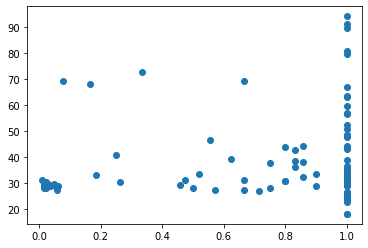

In [53]:
# plot the plots
plt.scatter(merchant_fraud_share_agg_df["fraud_customer_share"], merchant_fraud_share_agg_df["merchant_fraud_prob"])

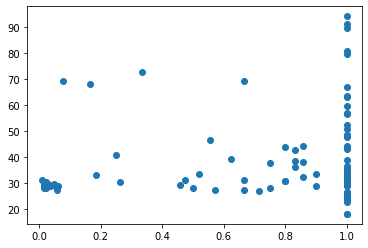

In [54]:
plt.scatter(merchant_fraud_share_agg_df["fraud_order_share"], merchant_fraud_share_agg_df["merchant_fraud_prob"])

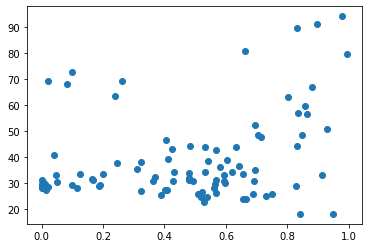

In [55]:
plt.scatter(merchant_fraud_share_agg_df["weighted_fraud_value_share"], merchant_fraud_share_agg_df["merchant_fraud_prob"])

Interaction between fraud consumer and merchant fraud is not obvious

## Customer data

definition: 
transaction : raw transaction data in parquet dataframe
consumer_fraud_df : pandas dataframe from consumer fraud csv



In [56]:
# join transaction and consumer_fraud by orderdate time and userid
# filtered_transaction_drop = filtered_transaction.drop("log(dollar_value)")
consumer_fraud_df.to_parquet("../data/curated/consumer_fraud.parquet")
transaction.printSchema()
# filtered_transaction_drop.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- log(dollar_value): double (nullable = true)



In [57]:
consumer_fraud_sdf = spark.read.parquet("../data/curated/consumer_fraud.parquet")

In [58]:
consumer_fraud_sdf.printSchema()
# print(consumer_fraud_sdf.distinct().count()) #34765 distince fraud transactions

root
 |-- user_id: long (nullable = true)
 |-- order_datetime: string (nullable = true)
 |-- fraud_probability: double (nullable = true)



In [59]:
consumer_fraud_sdf.select("user_id").distinct().count() #20128 distinct user id in consumer fraud
transaction.select("user_id").distinct().count() #24081 distinct user_id in historical transactions

24081

In [60]:
labeled_consumer = consumer_fraud_df["user_id"].unique().tolist() # len(labeled_consumer) = 20128
label_consumer_historical_transaction_sdf = transaction.where(F.col('user_id').isin(labeled_consumer))

label_consumer_fraud_transaction_sdf = label_consumer_historical_transaction_sdf.join(consumer_fraud_sdf, on=["user_id","order_datetime"])

In [61]:
# get historical avg for consumer 
# consumer profile: avg_spending_per_order, no_store, no_order

consumer_daily_agg_sdf = label_consumer_historical_transaction_sdf.groupBy(["user_id","order_datetime"]).agg(
    F.countDistinct(F.col('merchant_abn')).alias('no_store'),
    F.countDistinct(F.col('order_id')).alias('no_order'),
    F.avg(F.col("dollar_value")).alias("avg_spending_per_order"),    
)

consumer_agg_sdf = consumer_daily_agg_sdf.groupby('user_id').agg(
    F.avg(F.col("no_store")).alias("avg_daily_no_store"),
    F.stddev(F.col("no_store")).alias("stddev_daily_no_store"),
    F.avg(F.col("no_order")).alias("avg_daily_no_order"),
    F.stddev(F.col("no_order")).alias("stddev_daily_no_order"),
    F.avg(F.col("avg_spending_per_order")).alias("all_time_avg_spending_per_order"),
    F.stddev(F.col("avg_spending_per_order")).alias("all_time_stddev_spending_per_order"),
) 


consumer_agg_df = consumer_agg_sdf.toPandas()

22/09/21 15:30:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/09/21 15:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 15:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 15:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 15:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 15:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 15:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 15:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 15:30:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will no

In [62]:
consumer_agg_df.head(1)

,user_id,avg_daily_no_store,stddev_daily_no_store,avg_daily_no_order,stddev_daily_no_order,all_time_avg_spending_per_order,all_time_stddev_spending_per_order
0,11625,1.582173,0.824428,1.587744,0.827236,139.612291,211.252577


In [63]:
# get the avg_spending_per_order, no_store, no_order from fraud data
consumer_fraud_agg_sdf = label_consumer_fraud_transaction_sdf.groupBy(["user_id","order_datetime"]).agg(
    F.countDistinct(F.col('merchant_abn')).alias('no_store'),
    F.countDistinct(F.col('order_id')).alias('no_order'),
    F.avg(F.col("dollar_value")).alias("avg_spending_per_order"),  
    F.mean(F.col("fraud_probability")).alias("fraud_prob")  # suggestions?
)

consumer_fraud_agg_df = consumer_fraud_agg_sdf.toPandas()

22/09/21 15:31:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/09/21 15:31:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/09/21 15:31:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


In [64]:
consumer_fraud_agg_df.head(1)

,user_id,order_datetime,no_store,no_order,avg_spending_per_order,fraud_prob
0,8814,2021-11-29,6,6,374.408441,8.880672


In [65]:
consumer_agg_df.head(1)

,user_id,avg_daily_no_store,stddev_daily_no_store,avg_daily_no_order,stddev_daily_no_order,all_time_avg_spending_per_order,all_time_stddev_spending_per_order
0,11625,1.582173,0.824428,1.587744,0.827236,139.612291,211.252577


In [66]:
# calculate the p vals

from scipy import stats
def two_side_p_val(mean, stddev, test):
    norm_dist = stats.norm(loc=mean, scale=stddev)
    if test > mean:
        return 2* (1-norm_dist.cdf(test))
    else:
        return 2*norm_dist.cdf(test)

def join_prob_p_val(mux, stdx, muy, stdy, testx, testy):
    distx = stats.norm(loc=mux, scale=stdx)
    disty = stats.norm(loc=muy, scale=stdy)
    joint_prob = distx.cdf(testx) * disty.cdf(testy)
    if joint_prob>0.5:
        return 2* (1-joint_prob)
    else:
        return 2*joint_prob


consumer_fraud_join_df = consumer_agg_df.merge(consumer_fraud_agg_df,on="user_id")


consumer_fraud_join_df["no_order_p_val"] = consumer_fraud_join_df[['avg_daily_no_order','stddev_daily_no_order',"no_order"]].\
    apply(lambda row:two_side_p_val(row[0],row[1],row[2]),axis=1)

consumer_fraud_join_df["no_store_p_val"] = consumer_fraud_join_df[['avg_daily_no_store','stddev_daily_no_store',"no_store"]].\
    apply(lambda row:two_side_p_val(row[0],row[1],row[2]),axis=1)

consumer_fraud_join_df["avg_spending_per_order_p_val"] = consumer_fraud_join_df[['all_time_avg_spending_per_order','all_time_stddev_spending_per_order',"avg_spending_per_order"]].\
    apply(lambda row:two_side_p_val(row[0],row[1],row[2]),axis=1)

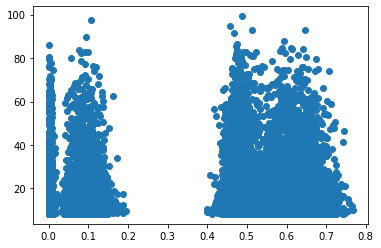

In [67]:
# draw the graphs
# bimodal, uniform distributed
plt.scatter(consumer_fraud_join_df["no_order_p_val"],consumer_fraud_join_df["fraud_prob"])

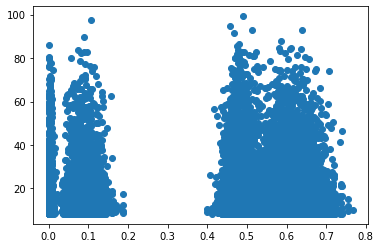

In [68]:
plt.scatter(consumer_fraud_join_df["no_store_p_val"],consumer_fraud_join_df["fraud_prob"])

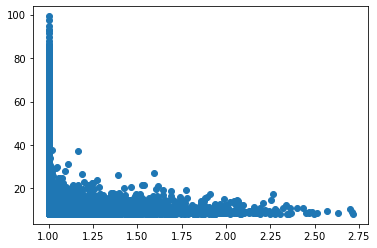

In [69]:
plt.scatter(np.exp(consumer_fraud_join_df["avg_spending_per_order_p_val"]),consumer_fraud_join_df["fraud_prob"])

In [70]:
consumer_fraud_join_df.to_csv("../data/curated/consumer_fraud_join.csv")

Similar to merchant data, the avg daily spending per order shows a nice negative trend. 

no Order and no stores shows a bimodal model, which shows possible artificiality of the data??

### for team to discuss

should we remove/discount transaction using the delta transaction file?

# Semi Supervised SVM Idea
output features: is_fraud for merchant and customer
two svm model
Threshold 50%? (which ever separates them the best cross validation)


### Features
#### Coming from merchant: 
no_order_p_val, no_customer_p_val, total_dollar_value_p_val

#### Coming from customer(discounted by fraudulent probability):
fraud_customer_share
fraud_order_share
fraud_dollar_amount_share

### Method


In [71]:
consumer = spark.read.parquet("../data/tables/consumer_user_details.parquet")
# consumer.toPandas() # 49999 distinct consumers



In [72]:
consumer_transaction_sdf = transaction.join(consumer.select("user_id"), on="user_id")